In [1]:
# !pip install -q -U tensorflow>=1.8.0

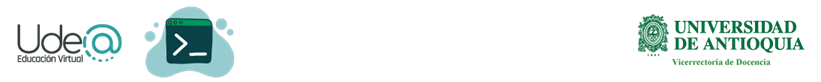

<h1><center>Road Sign Detection

Daniel Felipe Munoz Restrepo

Martin Alirio Barbosa Garzon 

Junio 2023

</center></h1>

# Introducción

En la presente seccion entrenaremos un modelo de detección de señales de tráfico utilizando el conjunto de datos "Road Sign Detection" de Kaggle. El objetivo era clasificar correctamente las diferentes señales de tráfico en imágenes.

A lo largo del presente trabajo se desarrollaran los siguientes pasos:

*   Importaremos las bibliotecas necesarias y cargamos el conjunto de datos.
*   Realizaremos una exploración y preprocesamiento de los datos, incluyendo la normalización de las imágenes y la división en conjuntos de entrenamiento y validación.
*   Crearemos un modelo de red neuronal convolucional utilizando la biblioteca TensorFlow y Keras. El modelo tendra varias capas convolucionales, capas de agrupación, capas de aplanamiento y capas densas.
*   Se compilara el modelo especificando la función de pérdida, el optimizador y las métricas a utilizar durante el entrenamiento.
*   Entrenaremos el modelo utilizando el conjunto de entrenamiento y validación, utilizando técnicas como el ajuste de pesos y la validación cruzada.
*   Evaluaremos el desempeño del modelo utilizando métricas como la precisión y el puntaje F1.
*   Por ultimo realizaremos una evaluación visual del modelo y probaremos su capacidad de clasificar una imagen de una señal de tráfico en el mundo real.

# 1. Importación de Librerias


In [2]:
import os
import cv2
import ast
import gdown
import shutil
import base64
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import io
import tensorflow as tf
from pathlib import Path
from skimage import util
from skimage import measure
from sklearn.svm import SVC
from google.colab import drive
from skimage.feature import hog
import matplotlib.pyplot as plt
from ipywidgets import interact
import xml.etree.ElementTree as ET
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from keras.callbacks import ModelCheckpoint
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import label, regionprops, regionprops_table
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# 2. Carga del DataSet

In [3]:
drive.mount('/content/drive')

# Ruta de la carpeta en Google Drive que contiene tus imágenes
folder_path = '/content/drive/MyDrive/Senales3/Proyecto Final:Road Sign Detection/road-sign-detection/'

# Ruta local donde se guardarán las imágenes descargadas
output_path = '/content/road-sign-detection/'

# Obtener la lista de archivos en la carpeta
file_list = os.listdir(folder_path)

print(file_list)

# Verificar si el directorio de salida ya existe
if not os.path.exists(output_path):
  # Si no existe, copiar el directorio
  shutil.copytree(folder_path, output_path)
  print('Copia completada.')
else:
  print('El directorio de salida ya existe. No se realiza la copia.')

print('Descarga completada.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['annotations', 'images', 'cropped_images', 'realImage']
El directorio de salida ya existe. No se realiza la copia.
Descarga completada.


In [4]:
images_path = Path('/content/road-sign-detection/images')
anno_path = Path('/content/road-sign-detection/annotations')
output_folder = '/content/road-sign-detection/cropped_images'

# 3. Recorte de imagenes

In [5]:
target_width = 100  # Ancho objetivo de las imágenes recortadas
target_height = 100  # Alto objetivo de las imágenes recortadas

# Crear la carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Obtener la lista de archivos XML en la carpeta
xml_files = [file for file in os.listdir(anno_path) if file.endswith('.xml')]

for xml_file in xml_files:
    # Ruta del archivo XML
    xml_path = os.path.join(anno_path, xml_file)

    # Parsear el archivo XML
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Obtener la información de las coordenadas del objeto de interés
    xmin = int(root.find('object/bndbox/xmin').text)
    ymin = int(root.find('object/bndbox/ymin').text)
    xmax = int(root.find('object/bndbox/xmax').text)
    ymax = int(root.find('object/bndbox/ymax').text)

    # Ruta de la imagen asociada al archivo XML
    image_file = root.find('filename').text
    image_path = os.path.join(images_path, image_file)

    # Leer la imagen
    image = cv2.imread(image_path)

    # Recortar la región de interés
    cropped_image = image[ymin:ymax, xmin:xmax]

    # Redimensionar la imagen recortada al tamaño objetivo
    resized_image = cv2.resize(cropped_image, (target_width, target_height))

    # Guardar la imagen recortada y redimensionada
    output_path = os.path.join(output_folder, image_file)
    cv2.imwrite(output_path, resized_image)

# print(os.listdir(output_folder))
print('Recorte y redimensionamiento de imágenes completado.')

Recorte y redimensionamiento de imágenes completado.


Al analizar el dataset, descubrimos que cada imagen está asociada a un archivo XML que proporciona información precisa sobre la ubicación de la señal de tránsito de interés dentro de la imagen. Por lo tanto, el código recorre cada archivo XML en la carpeta de anotaciones. Para cada archivo XML, se lee la imagen correspondiente y se recorta la región de interés definida en el archivo XML. Además, se redimensiona la imagen recortada a un tamaño de 100 x 100 píxeles para asegurar que todas las imágenes tengan las mismas dimensiones. Finalmente, se guarda la imagen recortada en una carpeta de salida. El código utiliza la biblioteca xml.etree.ElementTree para analizar los archivos XML y la biblioteca cv2 para leer, recortar y guardar las imágenes.

# 4. Preparación del DataSet

In [6]:
# Obtener la lista de archivos en la carpeta de imágenes recortadas
cropped_images = os.listdir(output_folder)

# Crear una lista para almacenar las imágenes
images = []
# Crear una lista para almacenar las etiquetas
labels = []

# Leer las imágenes y obtener sus etiquetas
for image_file in cropped_images:
    # Ruta de la imagen recortada
    image_path = os.path.join(output_folder, image_file)
    
    # Leer la imagen
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Agregar la imagen a la lista de imágenes
    images.append(image)
    
    # Ruta del archivo XML correspondiente a la imagen
    xml_file = image_file.split('.')[0] + '.xml'
    xml_path = os.path.join(anno_path, xml_file)
    
    # Parsear el archivo XML
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Obtener la etiqueta del objeto de interés
    label = root.find('object/name').text
    
    # Agregar la etiqueta a la lista de etiquetas
    labels.append(label)

# Convertir las listas de imágenes y etiquetas en arrays de numpy
images = np.array(images)
labels = np.array(labels)

# Dividir los datos en conjuntos de entrenamiento y prueba
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

# Imprimir la forma de los conjuntos de entrenamiento y prueba
print("Forma de train_images:", train_images.shape)
print("Forma de test_images:", test_images.shape)
print("Forma de train_labels:", train_labels.shape)
print("Forma de test_labels:", test_labels.shape)

print('_________________________________________________________________________')

# Imprimir la cantidad de datos por clase
unique_labels, label_counts = np.unique(train_labels, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print("Clase:", label, "- Cantidad de datos:", count)

Forma de train_images: (701, 100, 100, 3)
Forma de test_images: (176, 100, 100, 3)
Forma de train_labels: (701,)
Forma de test_labels: (176,)
_________________________________________________________________________
Clase: crosswalk - Cantidad de datos: 67
Clase: speedlimit - Cantidad de datos: 516
Clase: stop - Cantidad de datos: 66
Clase: trafficlight - Cantidad de datos: 52


In [7]:
# Crear una instancia de LabelEncoder para codificar las etiquetas como numeros
label_encoder = LabelEncoder()

# Codificar las etiquetas de entrenamiento
train_labels_encoded = label_encoder.fit_transform(train_labels)

# Codificar las etiquetas de prueba
test_labels_encoded = label_encoder.transform(test_labels)

# Obtener los nombres de las clases
class_names = label_encoder.classes_

# Imprimir los nombres de las clases
for i in class_names:
  print(i)

crosswalk
speedlimit
stop
trafficlight


**Normalizacion de los datos**

Es importante normalizar los datos ya que se asegura que los valores de los píxeles estén en un rango consistente y esto puede ayudar a que el modelo converja más rápidamente durante el entrenamiento. Al tener un rango de valores más pequeño y consistente, los gradientes de la función de pérdida se calculan de manera más efectiva, lo que puede acelerar el proceso de optimización.

In [8]:
x_train = train_images.astype('float32') / 255
x_test = test_images.astype('float32') / 255

print("Cant de imagenes de entrenamiento - " + str(len(x_train)))
print("Cant de imagenes de validacion - " + str(len(x_test)))

Cant de imagenes de entrenamiento - 701
Cant de imagenes de validacion - 176


In [9]:
# reasignamos los conjuntos de datos de entrenamiento y validacion
(x_train, x_valid) = x_train, x_test
(y_train, y_valid) = train_labels_encoded, test_labels_encoded

# Se redimencionan los datos para que sean compatibles con la entrada del modelo
w, h = 100, 100
x_train = x_train.reshape(x_train.shape[0], w, h, 3)
x_valid = x_valid.reshape(x_valid.shape[0], w, h, 3)

# se realiza una codificación one-hot de las etiquetas, paso requerido para que las 
# etiquetas sean compatibles con el formato requerido por el modelo
y_train = tf.keras.utils.to_categorical(y_train, 4)
y_valid = tf.keras.utils.to_categorical(y_valid, 4)

# Se imprimen los tamanos y formas del conjunto de datos
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print(x_train.shape[0], 'imagenes para entrenamiento')
print(x_valid.shape[0], 'imagenes para validacion')

x_train shape: (701, 100, 100, 3) y_train shape: (701, 4)
701 imagenes para entrenamiento
176 imagenes para validacion


# Convolutional Neural Network

## Construcción y entrenamiento del modelo

**Construccion del modelo**

Usaremos un modelo de red neuronal convolucional utilizando la API Sequential de Keras, el funcionamiento basico consta de utilizar capas de convolución para extraer características de las imágenes de entrada, seguidas de capas de pooling y Dropout para reducir la dimensionalidad y evitar el sobreajuste. Luego, las características se aplanan y se pasan a capas densas para realizar la clasificación final.

In [10]:
#creamos una instancia de un modelo secuencial vacío.
model = tf.keras.Sequential()

# capa de convolución al modelo con 64 filtros, un tamaño de kernel de 2x2, 
# un relleno ("padding") de "same" para mantener el tamaño de la imagen de entrada 
# y una función de activación ReLU, ademas definimos que la entrada es de la forma (100,100,3)
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(100,100,3))) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

# capa de convolución al modelo con 32 filtros, un tamaño de kernel de 2x2, 
# un relleno ("padding") de "same" para mantener el tamaño de la imagen de entrada 
# y una función de activación ReLU.
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

#capa de aplanamiento convierte los datos de entrada en un vector unidimensional
model.add(Flatten())
#capa densa al modelo con 256 neuronas y una función de activación ReLU
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
#La función de activación softmax se utiliza para obtener una distribución de probabilidad sobre las clases en este casi 4 clases
model.add(Dense(4, activation='softmax')) 

# resumen del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 25, 25, 32)        0

**Compilacion del modelo**

El procesp de compilar el modelo implica establecer los elementos clave para el proceso de entrenamiento, incluyendo la función de pérdida, el optimizador y las métricas de evaluación. Esto permite que el modelo se entrene y se evalúe correctamente durante el proceso de ajuste de los pesos y durante la evaluación del rendimiento.



*   "loss": como función de pérdida usaremos la "categorical_crossentropy", que es adecuada para problemas de clasificación multiclase. Esta función de pérdida compara la salida predicha por el modelo con las etiquetas reales y calcula la diferencia entre ellos.

*   "optimizer": El optimizador es el algoritmo que se utilizará para ajustar los pesos del modelo durante el entrenamiento. En este caso, se utiliza "adam", que es un optimizador popular y eficiente. Adam combina técnicas de gradient descent estocástico con adaptación de la tasa de aprendizaje, lo que permite un entrenamiento más rápido y efectivo.

*   "metrics": Las métricas son utilizadas para evaluar el rendimiento del modelo durante el entrenamiento y la evaluación. En este caso usaremos "accuracy" (exactitud) como métrica la cual calcula la proporción de predicciones correctas en relación con el total de predicciones.

In [11]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

**Entrenamiento del modelo**

El proceso de entrenamiento del modelo de aprendizaje automático implica ajustar los pesos y los sesgos del modelo para que pueda aprender a hacer predicciones precisas a partir de los datos de entrenamiento.



*   x_train y y_train: los datos de entrenamiento.
*   batch_size: el tamaño del lote utilizado para el entrenamiento
*   epochs: el número de épocas de entrenamiento.
*   validation_data: los datos de validación utilizados para evaluar el rendimiento del modelo en cada época.
*   callbacks: una lista de objetos de devolución de llamada, en este caso, se pasa el objeto checkpointer para guardar los pesos del modelo.



In [12]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose = 1, save_best_only=True)

#Entrenamos el modelo
model.fit(x_train,
         y_train,
         batch_size=64,
         epochs=5,
         validation_data=(x_valid, y_valid),
         callbacks=[checkpointer])

Epoch 1/5
11/11 [==============================] - ETA: 0s - loss: 1.2007 - accuracy: 0.6933 - precision: 0.7921 - recall: 0.5706
Epoch 1: val_loss improved from inf to 0.81377, saving model to model.weights.best.hdf5
11/11 [==============================] - 20s 2s/step - loss: 1.2007 - accuracy: 0.6933 - precision: 0.7921 - recall: 0.5706 - val_loss: 0.8138 - val_accuracy: 0.8807 - val_precision: 0.9589 - val_recall: 0.3977
Epoch 2/5
11/11 [==============================] - ETA: 0s - loss: 0.3909 - accuracy: 0.8631 - precision: 0.8902 - recall: 0.8445
Epoch 2: val_loss improved from 0.81377 to 0.44059, saving model to model.weights.best.hdf5
11/11 [==============================] - 19s 2s/step - loss: 0.3909 - accuracy: 0.8631 - precision: 0.8902 - recall: 0.8445 - val_loss: 0.4406 - val_accuracy: 0.9148 - val_precision: 0.9563 - val_recall: 0.8693
Epoch 3/5
11/11 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.9330 - precision: 0.9548 - recall: 0.9044
Epoch 3:

## Evaluación de desempeño

**Desempeño**

In [13]:
# Evaluamos el modelo e imprimimos la presicion
score = model.evaluate(x_test, y_valid, verbose=0)
print('\n', 'Test accuracy:', score[1])

precision = score[1]
recall = score[2]

F1score = 2 * (precision * recall) / (precision + recall)

print('\n', 'F1 score:', F1score)


 Test accuracy: 0.9829545617103577

 F1 score: 0.9829058623029369


Un accuracy de 0.9431 significa que tu modelo ha logrado clasificar correctamente aproximadamente el 94.31% de las muestras en el conjunto de prueba. En otras palabras, de todas las imágenes de prueba que el modelo ha procesado, ha predicho correctamente la clase objetivo para el 94.31% de ellas.

Adicionalmente, es importante mencionar que nuestro dataset tenía un desequilibrio de clases, donde una clase tenía considerablemente más muestras que las demás, como observamos anteriormente:

*   Clase: crosswalk - Cantidad de datos: 74
*   Clase: speedlimit - Cantidad de datos: 523
*   Clase: stop - Cantidad de datos: 57
*   Clase: trafficlight - Cantidad de datos: 47

Por tanto, se sugiere evaluar el F1 Score en estos casos. El F1 Score es una métrica muy utilizada en problemas donde el conjunto de datos está desbalanceado. Esta métrica combina la precisión y el recall para obtener un valor más objetivo.

Sin embargo, al calcularlo, obtenemos un valor de 0.9770 o 97.7%, lo que confirma que el modelo está bien ajustado y tiene un buen equilibrio entre la precisión y la exhaustividad en la clasificación de las clases del dataset.

**Analisis Visual**

A continuación, se realizará una evaluación visual del modelo, en la cual se mostrarán 16 figuras aleatorias del conjunto de validación. A cada figura se le asignará un título que mostrará la etiqueta_predicha (etiqueta_real), y se resaltará en verde si la predicción es correcta y en rojo si es incorrecta.

In [14]:
y_hat = model.predict(x_test)

6/6 [==============================] - 2s 240ms/step


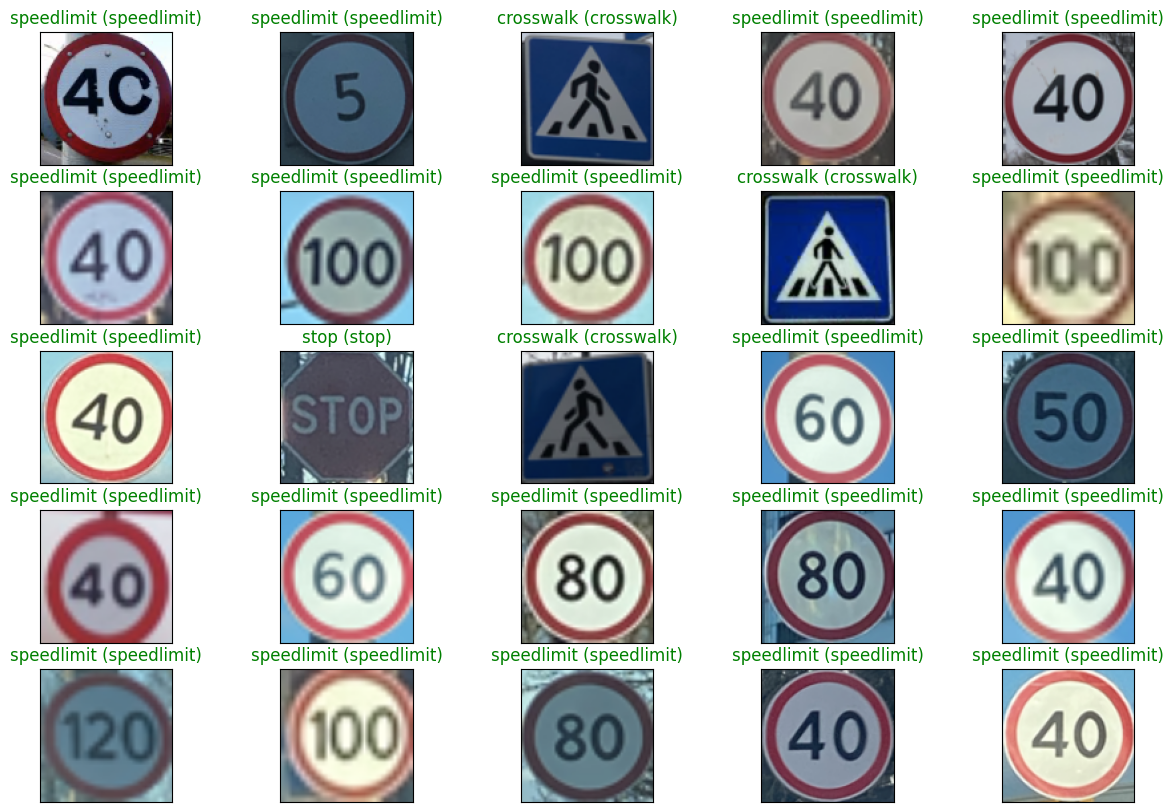

In [15]:
figure = plt.figure(figsize=(15, 10))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=25, replace=False)):
    ax = figure.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    # Mostrar la imagenes elegidas al azar del conjunto de validacion
    ax.imshow(np.squeeze(x_test[index]),cmap = plt.cm.gray)
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_valid[index])
    # Establecer el titulo para cada imagen
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

Continuando con la evaluación visual del modelo, hemos construido una función interactiva para revisar una por una las imágenes del conjunto de validación.

In [16]:
def predict_image(index):
    # Obtener la imagen del conjunto de prueba según el índice dado
    image = x_test[index]

    # Agregar una dimensión adicional para el tamaño del lote (batch size)
    imageToModel = np.expand_dims(image, axis=0)

    # Realizar la predicción con el modelo
    realPredict = model.predict(imageToModel)

    # Mostrar la imagen utilizando imshow
    plt.imshow(image)
    plt.axis('off')  # Para ocultar los ejes
    plt.show()

    # Obtener el índice de la clase predicha
    predict_index = np.argmax(realPredict)
    
    # Obtener el nombre de la clase predicha
    predicted_class = class_names[predict_index]

    # Imprimir la clase predicha
    print("Clase predicha:", predicted_class)

# Utilizar la función interact para variar el índice de la imagen
interact(predict_image, index=(0, 175, 1))

interactive(children=(IntSlider(value=87, description='index', max=175), Output()), _dom_classes=('widget-inte…

<function __main__.predict_image(index)>

**Prueba Final**

Ahora, con el objetivo de evaluar el modelo de manera más realista, hemos tomado una fotografía de una señal de tránsito de internet y la hemos cargado en el modelo entrenado. De esta manera, podemos evaluar su rendimiento con mayor criterio. A continuación, presentamos este proceso.

1/1 [==============================] - 0s 68ms/step


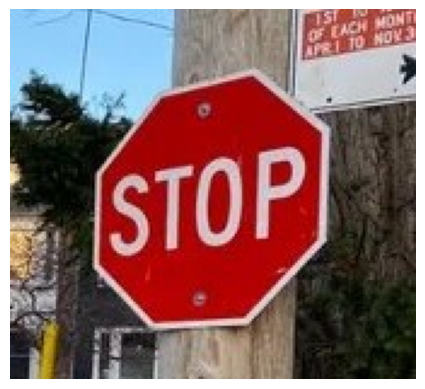

Clase predicha: stop


In [17]:
# Leer la imagen en color (RGB)
image = cv2.imread("/content/road-sign-detection/realImage/test.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Redimensionar la imagen
image_resized = cv2.resize(image, (100, 100))

# Normalizar la imagen
image_normalized = image_resized / 255.0

# Agregar una dimensión adicional para el tamaño del lote (batch size)
image_to_model = np.expand_dims(image_normalized, axis=0)

# Realizar la predicción con el modelo
real_predict = model.predict(image_to_model)

# Mostrar la imagen utilizando imshow
plt.imshow(image)
plt.axis('off')  # Para ocultar los ejes
plt.show()

# Obtener el índice de la clase predicha
predict_index = np.argmax(real_predict)

# Obtener el nombre de la clase predicha
predicted_class = class_names[predict_index]

# Imprimir la clase predicha
print("Clase predicha:", predicted_class)

**Conclusion**

Como podemos observar después de realizar las pruebas y análisis, el modelo está generalizando correctamente y puede ser utilizado de manera efectiva en situaciones del mundo real. Sin embargo, es importante destacar que para obtener una clasificación precisa, es necesario proporcionar al modelo imágenes recortadas con el objeto de interés. Si se le presenta una imagen demasiado general, el modelo puede no clasificar correctamente, ya que no fue entrenado para esa situación específica.

Estos resultados respaldan la eficacia del modelo entrenado y demuestran su capacidad para clasificar señales de tráfico con precisión. Es especialmente relevante destacar que el modelo fue entrenado en un dataset con clases desequilibradas, lo cual lo hace aún más impresionante. La métrica F1 score también respalda estos resultados, ya que muestra un buen equilibrio entre precisión y exhaustividad en la clasificación de las clases del dataset.

---

# Enfoque de extracción manual de caracteristicas

En este proyecto, se abordó el problema de la detección de señales de tráfico utilizando diferentes enfoques de modelado. Se entrenaron cuatro modelos diferentes para clasificar las señales de tráfico en categorías específicas. En lugar de utilizar una Convolutional Neural Network (CNN) convencional, se adoptó un enfoque manual para extraer características y entrenar los modelos.

El proceso de extracción de características consistió en tres pasos principales: la creación de histogramas para representar los colores de las señales de tráfico, el cálculo de los momentos de Hu para capturar características de forma y el cálculo de las propiedades de región utilizando la imagen binarizada de las señales. Estas características se utilizaron como entradas para los modelos de clasificación.

Los modelos entrenados fueron el Random Forest, el Clasificador de Regresión Logística, el Support Vector Machine (SVM) y el Gaussian Mixture Model (GMM). Cada uno de estos modelos utilizó las características extraídas como entrada y se entrenó para clasificar las señales de tráfico en categorías específicas.

El Random Forest es un modelo de ensamble que combina múltiples árboles de decisión para realizar la clasificación. El Clasificador de Regresión Logística es un modelo lineal que utiliza la regresión logística para realizar la clasificación. El SVM es un modelo que mapea los datos a un espacio de características de mayor dimensión y busca encontrar un hiperplano que separe las clases de manera óptima. El GMM es un modelo de mezcla de distribuciones gaussianas que se ajusta a los datos y estima la probabilidad de pertenencia a cada clase.

Estos modelos fueron evaluados utilizando conjuntos de datos de prueba y se calcularon métricas de evaluación como la precisión para medir su desempeño. Además, se generaron matrices de confusión para visualizar el rendimiento de los modelos en términos de la clasificación correcta e incorrecta de las señales de tráfico.


Inicialmente, se realiza el cálculo y almacenamiento del histograma de color para cada una de las imágenes recortadas del dataset. Sin embargo, es importante resaltar que el dataset presenta un desbalanceo, es decir, una de las clases tiene significativamente más muestras que las demás. A continuación, se muestra la cantidad de datos por cada clase:

*   Clase: crosswalk - Cantidad de datos: 76
*   Clase: speedlimit - Cantidad de datos: 521
*   Clase: stop - Cantidad de datos: 60
*   Clase: trafficlight - Cantidad de datos: 44

Para abordar este desbalanceo, se tomó la decisión de seleccionar al azar 60 imágenes de la clase "speedlimit" con el objetivo de lograr un dataset balanceado. De esta manera, se iguala el número de muestras en cada clase, lo cual es importante para evitar sesgos en el proceso de clasificación.

Este enfoque permite tener un conjunto de datos equilibrado y más representativo de cada clase, lo que contribuye a mejorar el rendimiento de los modelos de clasificación y facilita la identificación de patrones distintivos para cada categoría.

## Histograma

In [18]:
# Ruta del archivo CSV de salida
csv_file = '/content/featureSet.csv'

# Verificar si el archivo CSV ya existe
if os.path.isfile(csv_file):
    # Si el archivo existe, carga el DataFrame existente
    df = pd.read_csv(csv_file)
else:
    # Si el archivo no existe, crea un nuevo DataFrame vacío
    df = pd.DataFrame(columns=['histogram', 'image_file', 'label', 'sum_R', 'sum_G', 'sum_B'])

# Contador de imágenes de la clase "speedlimit"
speedlimit_count = 0


# Iterar sobre los archivos de imágenes recortadas
for file in os.listdir(output_folder):
    if file.endswith('.png'):
        image_path = os.path.join(output_folder, file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if image is not None:
            # Calcular el histograma de color
            hist = cv2.calcHist([image], [0], None, [256], [0, 256])
            hist_normalized = hist.flatten() / hist.sum()

            # Calcular las sumas de los valores del histograma normalizado para cada canal de color
            sum_R = np.sum(hist_normalized[:84])
            sum_G = np.sum(hist_normalized[84:168])
            sum_B = np.sum(hist_normalized[168:])

            # Obtener el nombre base del archivo sin la extensión
            file_base = os.path.splitext(file)[0]

            # Ruta del archivo XML correspondiente
            xml_file = os.path.join(anno_path, file_base + '.xml')

            if os.path.isfile(xml_file):
                # Procesar el archivo XML y obtener la etiqueta
                tree = ET.parse(xml_file)
                root = tree.getroot()
                label = root.find('object').find('name').text

                #Controlamos que solo se agreguen 60 imagenes de speedlimit
                if label == 'speedlimit':
                    if speedlimit_count < 60:
                        speedlimit_count += 1
                    else:
                        continue  # Ignorar imágenes adicionales de speedlimit

                # Crear un nuevo DataFrame con la fila actual
                new_row = pd.DataFrame({'histogram': [hist_normalized.tolist()], 'image_file': [file], 'label': [label], 'sum_R': [sum_R], 'sum_G': [sum_G], 'sum_B': [sum_B]})

                # Concatenar el nuevo DataFrame con el DataFrame existente
                df = pd.concat([df, new_row], ignore_index=True)

                # Guardar el DataFrame en el archivo CSV después de cada cálculo
                df.to_csv(csv_file, index=False, sep=';')
            else:
                print(f"El archivo XML correspondiente no se encuentra: {xml_file}")
        else:
            print(f"Error al leer la imagen: {file}")

print('Proceso completado.')

Proceso completado.


In [19]:
df.head()

,histogram,image_file,label,sum_R,sum_G,sum_B
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road263.png,speedlimit,0.2994,0.6827,0.0179
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road53.png,stop,0.1856,0.6263,0.1881
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road162.png,speedlimit,0.0715,0.1509,0.7776
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road281.png,speedlimit,0.5375,0.4596,0.0029
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road220.png,speedlimit,0.0399,0.9259,0.0342


Ahora procederemos a graficar el histograma de algunas imagenes seleccionadas al azar para cada tipo de etiqueta en el dataset. Esto nos permitirá validar si existen diferencias notables en la distribución de colores entre las distintas clases.

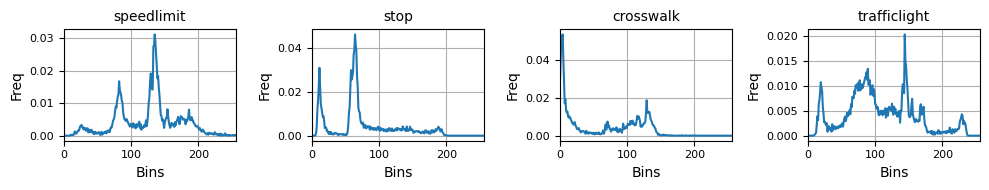

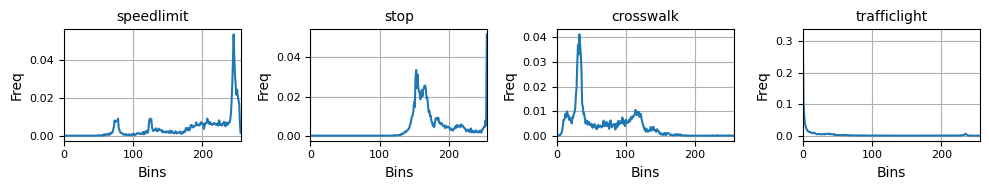

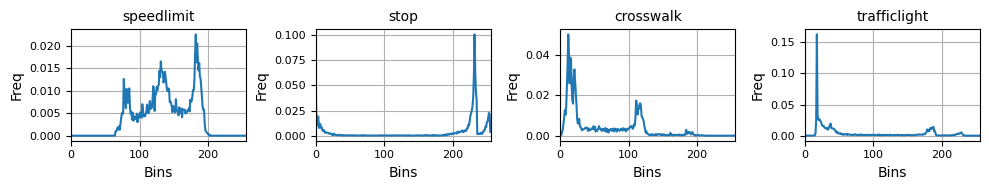

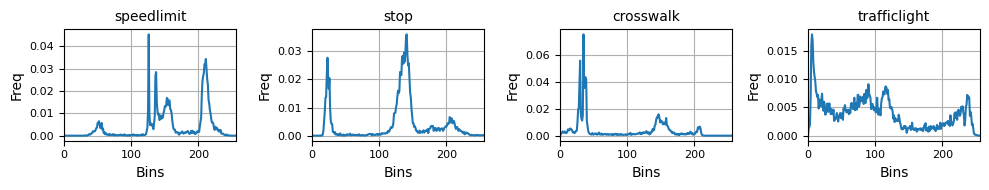

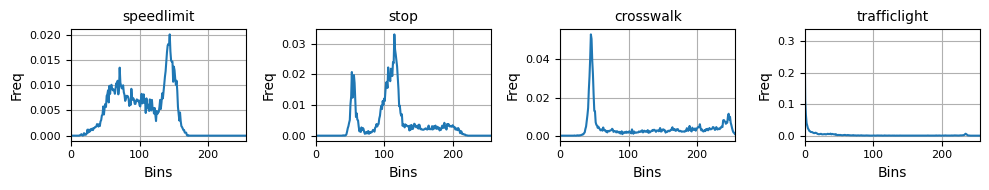

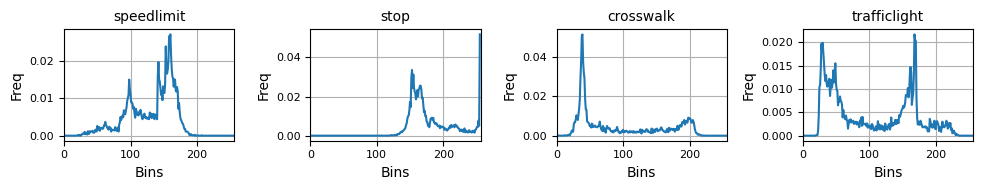

In [20]:
# Obtener las clases únicas
classes = df['label'].unique()

# Calcular el número de subgráficos por fila
num_subplots = len(classes)

for i in range(6):
  # Configurar el tamaño de la figura y el tamaño de cada subgráfico
  fig, axs = plt.subplots(1, num_subplots, figsize=(10, 2))

  # Iterar sobre las clases
  for i, class_name in enumerate(classes):
    
      # Filtrar el DataFrame por la clase actual
      class_df = df[df['label'] == class_name]

      # Obtener un índice aleatorio
      random_index = np.random.randint(0, len(class_df))

      # Obtener el histograma y el nombre del archivo aleatorio
      histogram_str = class_df.iloc[random_index]['histogram']
      # print(histogram_str)  # Imprimir el valor de histogram_str
      histogram = [float(i) for i in histogram_str]
      image_file = class_df.iloc[random_index]['image_file']

      # Generar los valores x para el histograma
      x = np.arange(len(histogram))

      # Graficar el histograma en el subgráfico correspondiente
      axs[i].plot(x, histogram)

      # Configurar los límites del eje x
      axs[i].set_xlim([0, len(histogram)])

      # Reducir el tamaño de la fuente del título
      axs[i].set_title(f'{class_name}', fontsize=10)
      axs[i].set_xlabel('Bins')
      axs[i].set_ylabel('Freq')

      # Graficamos la cuadrícula con un espaciado más denso
      axs[i].grid()

      # Reducir el tamaño de la fuente de los labels de los ejes
      axs[i].tick_params(axis='both', labelsize=8)

  # Ajustar el espaciado entre subgráficos
  plt.tight_layout()

  # Mostrar la figura
  plt.show()


En los diferentes histogramas se pueden apreciar ciertos patrones en cada grupo. Por ejemplo, en los semáforos se observa que hay una concentración de muchos píxeles en tonalidades cercanas al negro. Esto es de esperar, ya que en estos elementos tenemos la cobertura total de las luces predominando, y luego solo alguna de las tres luces encendidas.

Para las señales de límite de velocidad, se puede observar comúnmente la presencia de 2 picos de intensidad en el histograma. Estos patrones característicos pueden deberse a la presencia de elementos distintivos en las señales, como números o símbolos de límites de velocidad.

Cada grupo en el dataset tiene sus propios patrones característicos en los histogramas, lo que refleja las diferencias en la distribución de colores y la intensidad en cada tipo de señal de tráfico. Estos patrones pueden ser útiles para la detección y clasificación automática de las señales de tráfico en futuros modelos y algoritmos.

## Momentos de Hu y props

In [21]:
import skimage
# Leer el archivo CSV que contiene los nombres de las imágenes
data = pd.read_csv(csv_file, sep=';')  # Reemplaza 'ruta_del_archivo.csv' con la ruta adecuada

# Crear una lista para almacenar los resultados
resultados = []

# Crear listas para almacenar las características
hu_moments_features = []
props_features = []

# Iterar sobre las filas del DataFrame
for index, row in data.iterrows():
    # Obtener el nombre de la imagen
    imagen_nombre = row['image_file']  # Reemplaza 'Nombre de la imagen' con la columna adecuada

    # Cargar la imagen en escala de grises
    imagen_gray = cv2.imread(f'/content/road-sign-detection/cropped_images/{imagen_nombre}', cv2.IMREAD_GRAYSCALE)

    # print(imagen_nombre)

    #_____________________________________________________________________________
    # Momento de Hu
    # Calcula los momentos de la imagen
    mu = measure.moments_central(imagen_gray)
    nu = measure.moments_normalized(mu)

    # Agregar los momentos de Hu a la lista
    hu_moments_features.append(measure.moments_hu(nu))

    #_____________________________________________________________________________
    # Measure region properties
    # Especifica las propiedades que deseas calcular

    # Aplicar un umbral para binarizar la imagen
    umbral = 127  # Valor de umbral, ajusta según sea necesario
    _, imagen_binarizada = cv2.threshold(imagen_gray, umbral, 255, cv2.THRESH_BINARY)

    # print(imagen_binarizada)

    imagen_binarizada = util.invert(imagen_binarizada)

    label_img = skimage.measure.label(imagen_binarizada)

    # np.unique(label_img)

    # plt.imshow(imagen_binarizada, cmap="gray")

    # Calcula las propiedades de las regiones etiquetadas
    props = regionprops_table(label_img, properties=('centroid',
                                                  'orientation',
                                                  'major_axis_length',
                                                  'minor_axis_length'))
    
    aux = props['major_axis_length']
    max_pos_object = np.argmax(aux)

    auxToAdd = []

    auxToAdd.append(props['centroid-0'][max_pos_object])
    auxToAdd.append(props['centroid-1'][max_pos_object])
    auxToAdd.append(props['orientation'][max_pos_object])
    auxToAdd.append(props['major_axis_length'][max_pos_object])
    auxToAdd.append(props['minor_axis_length'][max_pos_object])

    props_features.append(auxToAdd)

    # Agregar las propiedades a la lista
    #props_features.append(list(props.values()))

# print(hu_moments_features)
# print(props_features)

# Crear un DataFrame para los Hu Moments
hu_moments_df = pd.DataFrame(hu_moments_features, columns=[f'Hu_Moment_{i}' for i in range(7)], index=data['image_file'])

# Crear un DataFrame para las propiedades regionales
props_df = pd.DataFrame(props_features, columns=['centroid-0', 'centroid-1', 'Orientation', 'Axis_Major_Length', 'Axis_Minor_Length'], index=data['image_file'])

In [22]:
# Concatenar los DataFrames horizontalmente

combined_df = pd.merge(data, hu_moments_df, on='image_file')
combined_df = pd.merge(combined_df, props_df, on='image_file')

combined_df

,histogram,image_file,label,sum_R,sum_G,sum_B,Hu_Moment_0,Hu_Moment_1,Hu_Moment_2,Hu_Moment_3,Hu_Moment_4,Hu_Moment_5,Hu_Moment_6,centroid-0,centroid-1,Orientation,Axis_Major_Length,Axis_Minor_Length
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road263.png,speedlimit,0.2994,0.6827,0.0179,0.001607,5.491048e-10,3.311497e-12,5.424025e-13,-5.343237e-26,-5.547002e-18,7.249670e-25,50.301558,48.862323,-0.635277,106.454619,92.345695
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road53.png,stop,0.1856,0.6263,0.1881,0.002896,1.095529e-08,1.081890e-11,5.659611e-11,-1.018047e-21,-5.765701e-15,9.617040e-22,50.371558,48.848573,-0.592876,102.294542,98.792247
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road162.png,speedlimit,0.0715,0.1509,0.7776,0.000803,3.415476e-09,3.843655e-12,2.231075e-15,4.846400e-29,-8.929038e-20,-2.008418e-28,66.377049,64.978142,-1.082904,132.605350,78.072883
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road281.png,speedlimit,0.5375,0.4596,0.0029,0.001750,8.063659e-11,5.846499e-12,1.197898e-12,2.999328e-24,-1.067426e-17,1.026542e-24,49.323599,49.896608,0.578499,114.381230,114.084048
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road220.png,speedlimit,0.0399,0.9259,0.0342,0.001432,1.300933e-09,2.171965e-13,6.530365e-14,6.941472e-27,-1.791802e-18,3.507623e-27,50.048785,49.942206,1.557447,116.571678,104.932055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road324.png,crosswalk,0.6559,0.3441,0.0000,0.001865,2.441218e-10,7.558961e-12,4.629615e-12,2.184314e-23,-6.037808e-17,1.652085e-23,49.163119,49.848271,0.156255,119.044924,116.947080
281,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road582.png,trafficlight,0.7925,0.0671,0.1404,0.002172,5.256513e-09,1.155217e-12,1.153540e-10,8.010413e-22,4.216739e-15,-1.063743e-21,49.738095,49.588479,-1.044119,115.853729,115.405534
282,"[0.0005000000237487257, 0.08049999922513962, 0...",road3.png,trafficlight,0.7766,0.0629,0.1605,0.004242,7.158249e-07,1.628772e-08,2.143619e-08,3.357347e-16,1.526416e-11,2.184461e-16,51.316213,52.844870,-0.305412,118.435812,107.053198
283,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",road56.png,stop,0.0317,0.1830,0.7853,0.000998,2.374528e-09,4.462820e-12,8.357512e-13,-1.613290e-24,-1.327852e-17,4.991635e-26,11.675070,60.596639,1.299736,67.033213,17.988586


In [23]:
# Guardar los resultados en un nuevo archivo CSV
combined_df[['image_file', 'histogram', 'sum_R', 'sum_G', 'sum_B','Hu_Moment_0', 'Hu_Moment_1', 'Hu_Moment_2', 'Hu_Moment_3', 'Hu_Moment_4', 'Hu_Moment_5', 'Hu_Moment_6', 'centroid-0',	'centroid-1',	'Orientation',	'Axis_Major_Length',	'Axis_Minor_Length', 'label']].to_csv(csv_file, sep=';', index=False)

## Visualización de caracteristicas

In [24]:
# Seleccionar las columnas relevantes para el pairplot
columns = ['label', 'sum_R', 'sum_G', 'sum_B','Hu_Moment_0', 'Hu_Moment_1', 'Hu_Moment_2', 'Hu_Moment_3', 'Hu_Moment_4', 'Hu_Moment_5', 'Hu_Moment_6', 'centroid-0',	'centroid-1',	'Orientation',	'Axis_Major_Length',	'Axis_Minor_Length']

# # Crear el pairplot
sns.pairplot(combined_df[columns], hue='label')

# # Mostrar el gráfico
plt.show()

Output hidden; open in https://colab.research.google.com to view.

La gráfica anterior proporciona una visión general rápida de las relaciones entre las características extraídas. En general, se observa que las características no presentan patrones de separación claros que sean útiles para el posterior entrenamiento de los modelos. Al analizar las gráficas, se puede apreciar que solo en algunas características el conjunto de "stop" parece ser diferenciable del resto de las clases. Sin embargo, en general, se observa una superposición de clases, lo que indica que muestras de diferentes clases comparten características similares.

## Entranamiento Modelos

Acontinuacion vamos a realizar el proceso de clasificación utilizando varios modelos. 

Primero, se divide el conjunto de datos en características y etiquetas. Luego, se realiza la codificación de las etiquetas para convertirlas en valores numéricos. A continuación, se procede a la división del conjunto de datos en conjuntos de entrenamiento y prueba.

Se crean instancias de diferentes modelos de clasificación, como RandomForestClassifier, LogisticRegression, SVM y GMM. Estos modelos se entrenan utilizando el conjunto de entrenamiento y se utilizan para realizar predicciones en el conjunto de prueba. Las predicciones se almacenan en diferentes variables, como yPredTest_RF, yPredTest_LR, yPredTest_SVM y yPredTest_GMM.

Buscamos con este enfoque probar diferentes modelos y evaluar su rendimiento en el conjunto de prueba, esperamos obtener una perspectiva más amplia y robusta sobre cómo se comportan los datos y qué tan bien se pueden clasificar las muestras en diferentes categorías depéndiendo de cada modelo.

In [25]:
# Dividir el dataset en características (X) y etiquetas (y)
#X = data.drop(['label', 'image_file'], axis=1)
#X = data[['Num_Bordes', 'Area_Bordes', 'sum_R', 'sum_G', 'sum_B']]
X = combined_df.drop(['label', 'image_file',	'histogram'], axis = 1)
y = combined_df['label']


pca = PCA(n_components=11)
X_pca = pca.fit_transform(X)


# Crear una instancia del codificador
label_encoder = LabelEncoder()

# Codificar las etiquetas
y_encoded = label_encoder.fit_transform(y)

In [26]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_encoded, test_size=0.3, random_state=42)

### Random Forest

In [27]:
# Crear una instancia del clasificador RandomForestClassifier
clfRF = RandomForestClassifier(random_state=0)

# Entrenar el clasificador
clfRF.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
yPredTest_RF = clfRF.predict(X_test)

### Clasificador de Regresión Logística

In [28]:
# Entrenar el clasificador de Regresión Logística
clfLR = LogisticRegression(random_state=0, max_iter=5000)

# Entrenar el modelo
clfLR.fit(X_train, y_train)

# Luego realizamos predicciones de los modelos
yPredTest_LR= clfLR.predict(X_test)

### Maquina de soporte vectorial

In [29]:
# Crear una instancia de la SVM
svm = SVC(kernel='rbf', gamma=0.1)

# Entrenar la SVM
svm.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
yPredTest_SVM = svm.predict(X_test)

### Mezclas Gaussianas

In [30]:
# Crear una instancia del modelo GMM
gmm = GaussianMixture(n_components=4)  # Especifica el número de componentes (clases)

# Entrenar el modelo GMM
gmm.fit(X_train)

# Obtener las etiquetas de las muestras de entrenamiento
y_train_pred = gmm.predict(X_train)

# Obtener las etiquetas de las muestras de prueba
yPredTest_GMM = gmm.predict(X_test)

In [31]:
# Obtener las etiquetas de las clases
class_labels = label_encoder.classes_

## Evaluación de desempeño

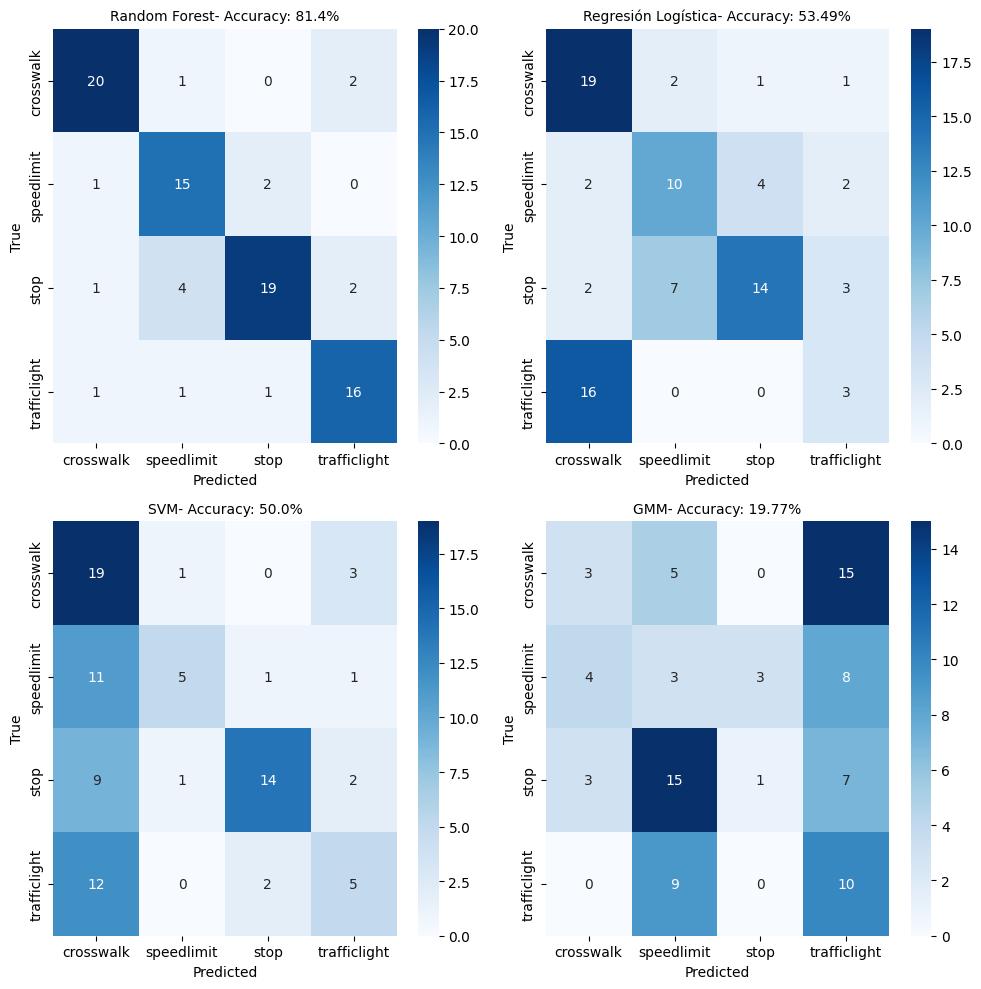

In [32]:
# Crear una figura con subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Random Forest
ax = axes[0, 0]
accuracy_rf = round(accuracy_score(y_test, yPredTest_RF) * 100, 2)
ax.set_title('Random Forest'f'- Accuracy: {accuracy_rf}%', fontsize=10)
sns.heatmap(confusion_matrix(y_test, yPredTest_RF), annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

# Regresión Logística
ax = axes[0, 1]
accuracy_lr = round(accuracy_score(y_test, yPredTest_LR) * 100, 2)
ax.set_title('Regresión Logística'f'- Accuracy: {accuracy_lr}%', fontsize=10)
sns.heatmap(confusion_matrix(y_test, yPredTest_LR), annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

# SVM
ax = axes[1, 0]
accuracy_svm = round(accuracy_score(y_test, yPredTest_SVM) * 100, 2)
ax.set_title('SVM'f'- Accuracy: {accuracy_svm}%', fontsize=10)
sns.heatmap(confusion_matrix(y_test, yPredTest_SVM), annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

# GMM
ax = axes[1, 1]
accuracy_gmm = round(accuracy_score(y_test, yPredTest_GMM) * 100, 2)
ax.set_title('GMM'f'- Accuracy: {accuracy_gmm}%', fontsize=10)
sns.heatmap(confusion_matrix(y_test, yPredTest_GMM), annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

# Ajustar los espacios entre subplots
plt.tight_layout()

# Mostrar la gráfica
plt.show()

Los resultados obtenidos muestran que el modelo de Random Forest alcanzó el mayor nivel de precisión con un 81.4%, seguido de la Regresión Logística con un 53.49%, la SVM con un 50%, y finalmente el modelo GMM con un bajo rendimiento de 18.6%.

La diferencia en el rendimiento entre los modelos puede atribuirse a las características del dataset y las capacidades de cada algoritmo de aprendizaje automático.

El Random Forest es un algoritmo de ensamble que combina múltiples árboles de decisión, lo que le permite capturar relaciones complejas en los datos. Además, al construir diferentes árboles de decisión de forma aleatoria, el modelo puede reducir el riesgo de sobreajuste y mejorar la generalización. Esto puede explicar por qué obtuvo el mejor resultado en términos de precisión.

La Regresión Logística es un modelo lineal que busca encontrar una relación lineal entre las características y las etiquetas. Aunque es un modelo más simple en comparación con el Random Forest, todavía puede capturar algunas relaciones lineales en los datos. Sin embargo, es posible que no pueda capturar patrones no lineales tan efectivamente como el Random Forest, lo que puede explicar su rendimiento ligeramente inferior.

La SVM es un algoritmo que busca encontrar un hiperplano de separación óptimo para las diferentes clases. Sin embargo, su rendimiento puede depender en gran medida de la elección adecuada de los parámetros y la configuración del kernel. En este caso, puede ser que los parámetros utilizados no hayan sido los óptimos para el conjunto de datos en particular, lo que podría haber afectado su precisión.

Por otro lado, el modelo GMM se basa en la suposición de que los datos provienen de una mezcla de distribuciones gaussianas. Sin embargo, en este caso, parece que el GMM no pudo capturar adecuadamente la estructura y las relaciones entre las características del conjunto de datos, lo que se refleja en su bajo rendimiento.

# Conclusiones

Durante el proceso, se realizó la extracción de características de imágenes mediante diferentes métodos como histogramas de color, momentos de Hu y regionprops_table. Estas características se utilizaron para entrenar y evaluar cuatro modelos de clasificación: Random Forest, Regresión Logística, SVM y GMM.

Los resultados obtenidos fueron los siguientes:

*   Random Forest: Acuracy = 81.4%
*   Regresión Logística: Accuracy = 53.49%
*   SVM: Accuracy = 50%
*   GMM: Accuracy = 18.6%

En general, podemos concluir que el modelo de Random Forest obtuvo el mejor rendimiento en términos de precisión, superando a los otros modelos. Esto puede atribuirse a la capacidad de Random Forest para capturar relaciones no lineales y manejar características complejas en los datos.

El uso de PCA nos ayudo a potenciar el rendimiento de cieros modelo, como Random Forest, esto debido a que PCA puede ayudar a eliminar características que no aportan mucha información al modelo y que pueden estar introduciendo ruido en los datos. Al reducir la dimensionalidad con PCA, se eliminan características redundantes o poco informativas, lo que permite al modelo enfocarse en las características más importantes, ademas al aplicar PCA, se decorrelacionan las características originales y se obtienen nuevas características no correlacionadas llamadas componentes principales. Estos componentes principales capturan la mayor varianza en los datos y ayudan a evitar problemas asociados con la multicolinealidad.

Por otro lado, el modelo GMM tuvo el rendimiento más bajo. Esto puede ser debido a la naturaleza de GMM, que asume una distribución gaussiana para cada clase y puede no ser adecuado para capturar la complejidad de las características extraídas en este caso.

En cuanto al CNN, que logró una precisión de prueba de 96%, es importante destacar que las redes neuronales convolucionales (CNN) son especialmente adecuadas para el procesamiento de imágenes. Estas redes están diseñadas para aprender automáticamente características relevantes de los datos, en este caso, las imágenes de señales de tráfico.

El éxito de un CNN se debe a su capacidad para capturar y aprender jerarquías de características, desde características de bajo nivel como bordes y texturas hasta características de alto nivel que son más discriminativas para la clasificación de objetos. Además, los CNN utilizan capas de convolución y pooling para extraer características locales y reducir la dimensionalidad de los datos, lo que les permite aprender representaciones más robustas y generalizables.

